In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
from citipy import citipy
import json
import time; time.time()

# Range of latitudes and longitudes
lat_range = (64, 20)
lng_range = (-154, -65)

# Output File (CSV)
output_data_file = "data/cities.csv"

# Import API key
from api_keys import weather_key

In [5]:
weather_data_df = pd.read_csv("data/tornadoes.csv")
weather_data_df.head()

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,ABSOLUTE_ROWNUMBER
0,866322,CARTERET CO.,TRUTTNEYS LNDG,11/1/2019,15,Tornado,,EF0,0,0,...,1,NNW,TRUTTNEYS LNDG,34.7394,-77.1094,34.7411,-77.1053,A brief tornado occurred near the intersection...,A strong cold front moved across Eastern North...,1
1,859389,MARTIN CO.,WAVELAND,11/5/2019,1620,Tornado,,EF0,0,0,...,2,ENE,WAVELAND,27.2140,-80.1729,27.2123,-80.1766,Martin County Beach Patrol reported a waterspo...,A strong thunderstorm produced a waterspout ju...,2
2,864077,MOBILE CO.,PRICHARD,11/7/2019,1335,Tornado,,EF0,0,0,...,0,SSE,PRICHARD,30.7248,-88.0548,30.7260,-88.0486,The storm survey team surveyed the areas aroun...,Thunderstorms moved across the area during the...,3
3,857862,FRANKLIN PAR.,BASKIN,11/26/2019,1803,Tornado,,EF2,1,1,...,4,NE,BASKIN,32.2351,-91.7783,32.3184,-91.7095,This tornado began on Roger Miller Road as it ...,"Warm, moist air was in place across northeast ...",4
4,857944,CLAIBORNE PAR.,MAHAN,11/26/2019,1820,Tornado,,EF1,0,0,...,2,NNE,MAHAN,32.9017,-93.0423,32.9076,-93.0343,An EF-1 tornado with estimated maximum winds a...,A deep southwesterly flow aloft ahead of a lar...,5


In [6]:
tornado_df = weather_data_df.loc[:,["BEGIN_LOCATION", "STATE_ABBR", "BEGIN_DATE", "EVENT_TYPE", "TOR_F_SCALE", "DEATHS_DIRECT", "BEGIN_LAT", "BEGIN_LON", "END_LOCATION"]]
tornado_df.head()

,BEGIN_LOCATION,STATE_ABBR,BEGIN_DATE,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,BEGIN_LAT,BEGIN_LON,END_LOCATION
0,TRUTTNEYS LNDG,NC,11/1/2019,Tornado,EF0,0,34.7394,-77.1094,TRUTTNEYS LNDG
1,WAVELAND,FL,11/5/2019,Tornado,EF0,0,27.2140,-80.1729,WAVELAND
2,PRICHARD,AL,11/7/2019,Tornado,EF0,0,30.7248,-88.0548,PRICHARD
3,BASKIN,LA,11/26/2019,Tornado,EF2,1,32.2351,-91.7783,BASKIN
4,MAHAN,LA,11/26/2019,Tornado,EF1,0,32.9017,-93.0423,MAHAN


In [7]:
gmaps.configure(api_key = weather_key)

In [8]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

525

In [9]:
for index, row in tornado_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=04c41275fea3e8291170fd88095dde0f"
    beg_lat= row['BEGIN_LAT']
    beg_lon= row['BEGIN_LON']

In [10]:
tornado_df = tornado_df.rename(columns={"BEGIN_LOCATION": "City", "BEGIN_LAT":"Lat", "BEGIN_LON":"Lng", "BEGIN_DATE": "Date"})
tornado_df.head()

,City,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION
0,TRUTTNEYS LNDG,NC,11/1/2019,Tornado,EF0,0,34.7394,-77.1094,TRUTTNEYS LNDG
1,WAVELAND,FL,11/5/2019,Tornado,EF0,0,27.2140,-80.1729,WAVELAND
2,PRICHARD,AL,11/7/2019,Tornado,EF0,0,30.7248,-88.0548,PRICHARD
3,BASKIN,LA,11/26/2019,Tornado,EF2,1,32.2351,-91.7783,BASKIN
4,MAHAN,LA,11/26/2019,Tornado,EF1,0,32.9017,-93.0423,MAHAN


In [11]:
cities_lat_lng = requests.get(base_url)

In [12]:
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=04c41275fea3e8291170fd88095dde0f"
# List of city data
city_data = []
# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")
# Create counters
record_count = 1
set_count = 1
# Loop through all the cities in our list
for x, city in enumerate(cities):
    # Group cities in sets of 50 for logging purposes
    if (x % 50 == 0 and x >= 50):
        set_count += 1
        record_count = 0
    # Create endpoint URL with each city
    city_url = url + "&q=" + city
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))
    # Add 1 to the record count
    record_count += 1
    # Run an API request for each of the cities
    try:
        # Parse the JSON and retrieve data
        city_weather = requests.get(city_url).json()
        # Parse out the max temp, humidity, and cloudiness
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]
        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})
    # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | san quintin
Processing Record 2 of Set 1 | oregon city
Processing Record 3 of Set 1 | fredonia
Processing Record 4 of Set 1 | mayo
Processing Record 5 of Set 1 | sitka
Processing Record 6 of Set 1 | guerrero negro
Processing Record 7 of Set 1 | attawapiskat
City not found. Skipping...
Processing Record 8 of Set 1 | kodiak
Processing Record 9 of Set 1 | praxedis guerrero
Processing Record 10 of Set 1 | foam lake
Processing Record 11 of Set 1 | safford
Processing Record 12 of Set 1 | castanos
Processing Record 13 of Set 1 | new ulm
Processing Record 14 of Set 1 | pemberton
Processing Record 15 of Set 1 | lake havasu city
Processing Record 16 of Set 1 | minot
Processing Record 17 of Set 1 | vincennes
Processing Record 18 of Set 1 | la ronge
Processing Record 19 of Set 1 | smithers
Processing Record 20 of Set 1 | meadow lake
Processing Record 21 of Set 1 | constitucion
Processing Record 22 of Set 1 |

Processing Record 44 of Set 4 | raton
Processing Record 45 of Set 4 | galveston
Processing Record 46 of Set 4 | ocean city
Processing Record 47 of Set 4 | woodstock
Processing Record 48 of Set 4 | tototlan
Processing Record 49 of Set 4 | williston
Processing Record 0 of Set 5 | fremont
Processing Record 1 of Set 5 | little current
Processing Record 2 of Set 5 | pampa
Processing Record 3 of Set 5 | university park
Processing Record 4 of Set 5 | eureka
Processing Record 5 of Set 5 | jasper
Processing Record 6 of Set 5 | marathon
Processing Record 7 of Set 5 | freeport
Processing Record 8 of Set 5 | lamesa
Processing Record 9 of Set 5 | kenai
Processing Record 10 of Set 5 | hibbing
Processing Record 11 of Set 5 | hurricane
Processing Record 12 of Set 5 | high level
Processing Record 13 of Set 5 | graham
Processing Record 14 of Set 5 | fort smith
Processing Record 15 of Set 5 | hoquiam
Processing Record 16 of Set 5 | hutchinson
Processing Record 17 of Set 5 | frederick
Processing Record 18

Processing Record 37 of Set 8 | san fernando
Processing Record 38 of Set 8 | evansville
Processing Record 39 of Set 8 | pinar del rio
Processing Record 40 of Set 8 | pitiquito
Processing Record 41 of Set 8 | oildale
Processing Record 42 of Set 8 | middlebury
Processing Record 43 of Set 8 | tamiahua
Processing Record 44 of Set 8 | winchester
Processing Record 45 of Set 8 | edgewood
Processing Record 46 of Set 8 | moron
Processing Record 47 of Set 8 | orange cove
Processing Record 48 of Set 8 | chatham
Processing Record 49 of Set 8 | kedgwick
Processing Record 0 of Set 9 | holyoke
Processing Record 1 of Set 9 | lovington
Processing Record 2 of Set 9 | la llave
Processing Record 3 of Set 9 | nombre de dios
Processing Record 4 of Set 9 | saint-agapit
Processing Record 5 of Set 9 | port hueneme
Processing Record 6 of Set 9 | siloam springs
Processing Record 7 of Set 9 | twentynine palms
Processing Record 8 of Set 9 | sutton
Processing Record 9 of Set 9 | ada
Processing Record 10 of Set 9 | 

In [13]:
city_data_pd = pd.DataFrame(city_data)
city_data_pd.count()

City          513
Lat           513
Lng           513
Max Temp      513
Humidity      513
Cloudiness    513
Wind Speed    513
Country       513
Date          513
dtype: int64

In [14]:
# Export the City_Data into a csv
city_data_pd.to_csv(output_data_file, index_label="City")

In [15]:
city_data_pd.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,san quintin,30.4833,-115.9500,60.03,60,23,18.97,MX,1615836548
1,oregon city,45.3573,-122.6068,46.00,65,40,3.44,US,1615836549
2,fredonia,42.4401,-79.3317,35.01,37,1,11.50,US,1615836273
3,mayo,38.8876,-76.5119,46.00,26,1,4.61,US,1615836549
4,sitka,57.0531,-135.3300,37.40,87,90,10.36,US,1615836549


In [16]:
america_city = city_data_pd[(city_data_pd["Country"]=="US")]
america_city

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
1,oregon city,45.3573,-122.6068,46.00,65,40,3.44,US,1615836549
2,fredonia,42.4401,-79.3317,35.01,37,1,11.50,US,1615836273
3,mayo,38.8876,-76.5119,46.00,26,1,4.61,US,1615836549
4,sitka,57.0531,-135.3300,37.40,87,90,10.36,US,1615836549
6,kodiak,57.7900,-152.4072,33.80,64,90,4.61,US,1615836550
...,...,...,...,...,...,...,...,...,...
505,guymon,36.6828,-101.4816,51.80,50,1,12.66,US,1615836689
506,elmira,42.0898,-76.8077,32.00,32,1,11.50,US,1615836586
507,rancho palos verdes,33.7445,-118.3870,55.00,66,40,21.85,US,1615836562
509,fort stewart,31.8722,-81.6100,75.00,100,75,14.97,US,1615836690


In [17]:
tornado_df2=tornado_df.copy()

In [18]:
tornado_df["City"] = tornado_df["City"].str.lower()
tornado_df

,City,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION
0,truttneys lndg,NC,11/1/2019,Tornado,EF0,0,34.7394,-77.1094,TRUTTNEYS LNDG
1,waveland,FL,11/5/2019,Tornado,EF0,0,27.2140,-80.1729,WAVELAND
2,prichard,AL,11/7/2019,Tornado,EF0,0,30.7248,-88.0548,PRICHARD
3,baskin,LA,11/26/2019,Tornado,EF2,1,32.2351,-91.7783,BASKIN
4,mahan,LA,11/26/2019,Tornado,EF1,0,32.9017,-93.0423,MAHAN
...,...,...,...,...,...,...,...,...,...
495,lamont,GA,4/13/2020,Tornado,EF0,0,32.9896,-84.1225,LAMONT
496,red oak,GA,4/13/2020,Tornado,EF0,0,33.6288,-84.5263,RED OAK
497,collier,GA,4/13/2020,Tornado,EF3,0,33.0298,-84.0330,BRIGHTON MILLS
498,roberts xrds,GA,4/13/2020,Tornado,EF0,0,33.4560,-83.6449,ROBERTS XRDS


In [19]:
america_city.City = america_city.City.astype(str)
tornado_df.City = tornado_df.City.astype(str)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
concat_df=pd.concat([tornado_df.set_index("City"), america_city.set_index("City")], join="outer")
concat_df


,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION,Max Temp,Humidity,Cloudiness,Wind Speed,Country
City,,,,,,,,,,,,,
truttneys lndg,NC,11/1/2019,Tornado,EF0,0.0,34.7394,-77.1094,TRUTTNEYS LNDG,NaN,NaN,NaN,NaN,NaN
waveland,FL,11/5/2019,Tornado,EF0,0.0,27.2140,-80.1729,WAVELAND,NaN,NaN,NaN,NaN,NaN
prichard,AL,11/7/2019,Tornado,EF0,0.0,30.7248,-88.0548,PRICHARD,NaN,NaN,NaN,NaN,NaN
baskin,LA,11/26/2019,Tornado,EF2,1.0,32.2351,-91.7783,BASKIN,NaN,NaN,NaN,NaN,NaN
mahan,LA,11/26/2019,Tornado,EF1,0.0,32.9017,-93.0423,MAHAN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
guymon,NaN,1615836689,NaN,NaN,NaN,36.6828,-101.4816,NaN,51.8,50.0,1.0,12.66,US
elmira,NaN,1615836586,NaN,NaN,NaN,42.0898,-76.8077,NaN,32.0,32.0,1.0,11.50,US
rancho palos verdes,NaN,1615836562,NaN,NaN,NaN,33.7445,-118.3870,NaN,55.0,66.0,40.0,21.85,US


In [21]:
concat_df["Date"]=(pd.to_datetime(concat_df["Date"]))
concat_df

,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION,Max Temp,Humidity,Cloudiness,Wind Speed,Country
City,,,,,,,,,,,,,
truttneys lndg,NC,2019-11-01 00:00:00.000000000,Tornado,EF0,0.0,34.7394,-77.1094,TRUTTNEYS LNDG,NaN,NaN,NaN,NaN,NaN
waveland,FL,2019-11-05 00:00:00.000000000,Tornado,EF0,0.0,27.2140,-80.1729,WAVELAND,NaN,NaN,NaN,NaN,NaN
prichard,AL,2019-11-07 00:00:00.000000000,Tornado,EF0,0.0,30.7248,-88.0548,PRICHARD,NaN,NaN,NaN,NaN,NaN
baskin,LA,2019-11-26 00:00:00.000000000,Tornado,EF2,1.0,32.2351,-91.7783,BASKIN,NaN,NaN,NaN,NaN,NaN
mahan,LA,2019-11-26 00:00:00.000000000,Tornado,EF1,0.0,32.9017,-93.0423,MAHAN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
guymon,NaN,1970-01-01 00:00:01.615836689,NaN,NaN,NaN,36.6828,-101.4816,NaN,51.8,50.0,1.0,12.66,US
elmira,NaN,1970-01-01 00:00:01.615836586,NaN,NaN,NaN,42.0898,-76.8077,NaN,32.0,32.0,1.0,11.50,US
rancho palos verdes,NaN,1970-01-01 00:00:01.615836562,NaN,NaN,NaN,33.7445,-118.3870,NaN,55.0,66.0,40.0,21.85,US


In [22]:
concat_df["Date"] = concat_df["Date"].map(lambda ts: ts.strftime("%m-%d-%Y"))
concat_df

,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION,Max Temp,Humidity,Cloudiness,Wind Speed,Country
City,,,,,,,,,,,,,
truttneys lndg,NC,11-01-2019,Tornado,EF0,0.0,34.7394,-77.1094,TRUTTNEYS LNDG,NaN,NaN,NaN,NaN,NaN
waveland,FL,11-05-2019,Tornado,EF0,0.0,27.2140,-80.1729,WAVELAND,NaN,NaN,NaN,NaN,NaN
prichard,AL,11-07-2019,Tornado,EF0,0.0,30.7248,-88.0548,PRICHARD,NaN,NaN,NaN,NaN,NaN
baskin,LA,11-26-2019,Tornado,EF2,1.0,32.2351,-91.7783,BASKIN,NaN,NaN,NaN,NaN,NaN
mahan,LA,11-26-2019,Tornado,EF1,0.0,32.9017,-93.0423,MAHAN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
guymon,NaN,01-01-1970,NaN,NaN,NaN,36.6828,-101.4816,NaN,51.8,50.0,1.0,12.66,US
elmira,NaN,01-01-1970,NaN,NaN,NaN,42.0898,-76.8077,NaN,32.0,32.0,1.0,11.50,US
rancho palos verdes,NaN,01-01-1970,NaN,NaN,NaN,33.7445,-118.3870,NaN,55.0,66.0,40.0,21.85,US


In [23]:
filteredtime_df = concat_df.loc[(concat_df["Date"] >= "11-01-2019")]
filteredtime_df

,STATE_ABBR,Date,EVENT_TYPE,TOR_F_SCALE,DEATHS_DIRECT,Lat,Lng,END_LOCATION,Max Temp,Humidity,Cloudiness,Wind Speed,Country
City,,,,,,,,,,,,,
truttneys lndg,NC,11-01-2019,Tornado,EF0,0.0,34.7394,-77.1094,TRUTTNEYS LNDG,NaN,NaN,NaN,NaN,NaN
waveland,FL,11-05-2019,Tornado,EF0,0.0,27.2140,-80.1729,WAVELAND,NaN,NaN,NaN,NaN,NaN
prichard,AL,11-07-2019,Tornado,EF0,0.0,30.7248,-88.0548,PRICHARD,NaN,NaN,NaN,NaN,NaN
baskin,LA,11-26-2019,Tornado,EF2,1.0,32.2351,-91.7783,BASKIN,NaN,NaN,NaN,NaN,NaN
mahan,LA,11-26-2019,Tornado,EF1,0.0,32.9017,-93.0423,MAHAN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethel,MS,12-29-2019,Tornado,EF1,0.0,33.1628,-89.4323,MC COOL,NaN,NaN,NaN,NaN,NaN
weir,MS,12-29-2019,Tornado,EF1,0.0,33.2598,-89.2778,ACKERMAN CHOCTAW ARP,NaN,NaN,NaN,NaN,NaN
adaton,MS,12-29-2019,Tornado,EF0,0.0,33.4720,-89.0315,ADATON,NaN,NaN,NaN,NaN,NaN


In [24]:
Lat = filteredtime_df["Lat"]
max_temps = filteredtime_df["Max Temp"]
humidity = filteredtime_df["Humidity"]
cloudiness = filteredtime_df["Cloudiness"]
wind_speed = filteredtime_df["Wind Speed"]
TOR_F_SCALE = filteredtime_df["TOR_F_SCALE"]
Lng = filteredtime_df["Lng"]
DEATHS_DIRECT = filteredtime_df["DEATHS_DIRECT"]
# Export the City_Data into a csv
filteredtime_df.to_csv(output_data_file, index_label="City")

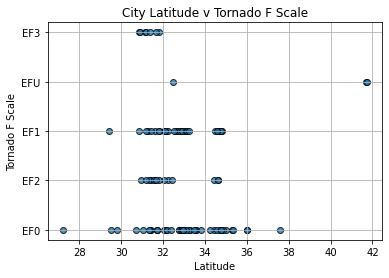

In [25]:
plt.scatter(Lat, TOR_F_SCALE, edgecolor="black", linewidth=1, marker="o", alpha=0.8, label="Cities")

plt.title(f"City Latitude v Tornado F Scale")
plt.xlabel("Latitude")
plt.ylabel("Tornado F Scale")
plt.grid(True)

plt.savefig("data/Fig1.png")
plt.show()

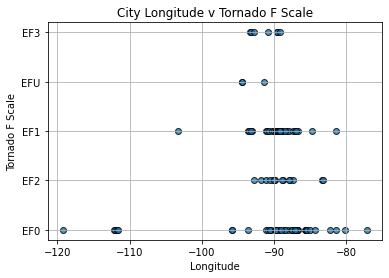

In [26]:
plt.scatter(Lng, TOR_F_SCALE, edgecolor="black", linewidth=1, marker="o", alpha=0.8, label="Cities")

plt.title(f"City Longitude v Tornado F Scale")
plt.xlabel("Longitude")
plt.ylabel("Tornado F Scale")
plt.grid(True)

plt.savefig("data/Fig1.png")
plt.show()

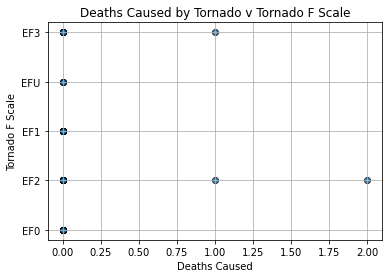

In [27]:
plt.scatter(DEATHS_DIRECT, TOR_F_SCALE, edgecolor="black", linewidth=1, marker="o", alpha=0.8, label="Cities")

plt.title(f"Deaths Caused by Tornado v Tornado F Scale")
plt.xlabel("Deaths Caused")
plt.ylabel("Tornado F Scale")
plt.grid(True)

plt.savefig("data/Fig1.png")
plt.show()

NameError: name 'gapminder_us' is not defined

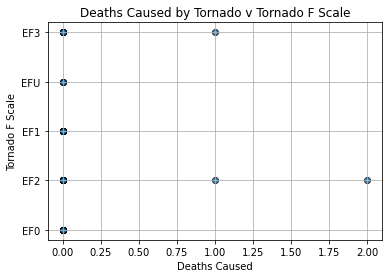

In [42]:
fig,ax2=plt.subplots()
plt.scatter(DEATHS_DIRECT, TOR_F_SCALE, edgecolor="black", linewidth=1, marker="o", alpha=0.8, label="Cities")

plt.title(f"Deaths Caused by Tornado v Tornado F Scale")
plt.xlabel("Deaths Caused")
plt.ylabel("Tornado F Scale")
plt.grid(True)
ax2.plot(gapminder_us.year, gapminder_us["gdpPercap"],color="blue",marker="o")
ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)
plt.show()

plt.savefig("data/Fig5.png")
plt.show()

In [39]:
ax2.plot(gapminder_us.year, gapminder_us["gdpPercap"],color="blue",marker="o")
ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)
plt.show()

NameError: name 'ax2' is not defined